In [ ]:
#In case google denies access for downloading the file, you can try by installing the lower version of gdown and clearing cache
!pip install -U --no-cache-dir gdown --pre

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9046 sha256=d180cd15d96281d7e51038a288e66af582b2558de25a91270e5d368f624a2529
  Stored in directory: /tmp/pip-ephem-wheel-cache-q3wmi47r/wheels/2f/2a/2f/86449b6bdbaa9aef873f68332b68be6bfbc386b9219f47157d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [ ]:
#Download the dataset
#Shared file link https://drive.google.com/file/d/1WfdEh2CyoV-cSNFyncKvLYhmD0rv2fFN/view?usp=sharing
#Alternatively you can download to your local computer an upload back to colab

!gdown --id '1WfdEh2CyoV-cSNFyncKvLYhmD0rv2fFN' --output acid_sub

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WfdEh2CyoV-cSNFyncKvLYhmD0rv2fFN
To: /content/acid_sub
100% 1.25G/1.25G [00:12<00:00, 101MB/s]


# Object Detection tutorial

For this tutorial, we will be finetuning a pre-trained [Faster R-CNN](https://arxiv.org/abs/1506.01497) model in the ACID dataset with 3 classes. It contains 3929 images with 8000+ instances of construction equipment, and we will use it to illustrate how to use the new features in torchvision in order to train an object detection model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-go0edwuy
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-go0edwuy
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264332 sha256=41933878fa97d956e5e9effb4ce3fd6061ddc5ce6e58276bb3731f8f352b0be3
  Stored in directory: /tmp/pip-ephem-wheel-cache-i285j5i2/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


### Writing a custom dataset for ACID

Let's write a dataset for the ACID dataset.

First, let's extract the data, present in a zip file

In [ ]:
!unzip acid_sub

Archive:  acid_sub
  inflating: 3classes/00001.jpg      
  inflating: 3classes/00002.jpg      
  inflating: 3classes/00010.jpg      
  inflating: 3classes/00011.jpg      
  inflating: 3classes/00012.jpg      
  inflating: 3classes/00013.jpg      
  inflating: 3classes/00018.jpg      
  inflating: 3classes/00021.jpg      
  inflating: 3classes/00022.jpg      
  inflating: 3classes/00025.jpg      
  inflating: 3classes/00028.jpg      
  inflating: 3classes/00030.jpg      
  inflating: 3classes/00031.jpg      
  inflating: 3classes/00034.jpg      
  inflating: 3classes/00037.jpg      
  inflating: 3classes/00038.jpg      
  inflating: 3classes/00041.jpg      
  inflating: 3classes/00042.jpg      
  inflating: 3classes/00043.jpg      
  inflating: 3classes/00047.jpg      
  inflating: 3classes/00051.jpg      
  inflating: 3classes/00053.jpg      
  inflating: 3classes/00059.jpg      
  inflating: 3classes/00066.jpg      
  inflating: 3classes/00076.jpg      
  inflating: 3classes/00080.jpg

Let's have a look at the dataset and how it is layed down.

The data is structured as follows
```
3classes/

    00001.jpg
    00002.jpg
    ....
    ....
    3classes.csv
    3classes.json
  
```

Here is one example of an image in the dataset

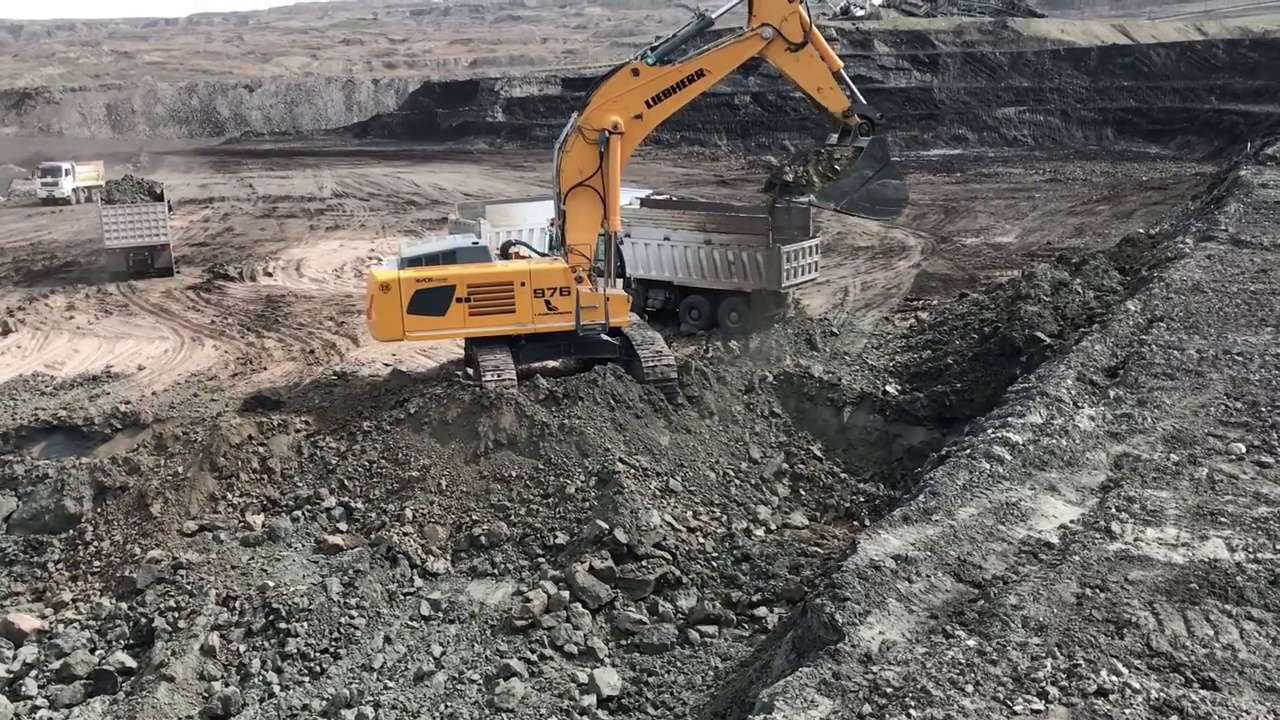

In [ ]:
from PIL import Image
import os
path = '/content/3classes/'
Image.open(os.path.join(path,'10031.jpg'))
#Image.open(path)

So each image has a corresponding bounding box. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from pycocotools.coco import COCO


class ACID_dataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))


    def __getitem__(self, idx):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[idx]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)

        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)


        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # get bounding box coordinates for each object
        #num_objs = len(obj_ids)
        num_objs = len(coco_annotation)

        boxes = []
        cat_ids = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            cat_id = coco_annotation[i]["category_id"]
            cat_ids.append(cat_id)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.as_tensor(cat_ids, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        print(target)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)

## Defining your model

In this tutorial, we will be using [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An object_detection model for Construction Equipment Detection

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_object_detection_model(num_classes):
    # load an object_detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 33394, done.
remote: Counting objects: 100% (5937/5937), done.
remote: Compressing objects: 100% (1299/1299), done.
remote: Total 33394 (delta 4720), reused 5659 (delta 4520), pack-reused 27457
Receiving objects: 100% (33394/33394), 42.07 MiB | 30.97 MiB/s, done.
Resolving deltas: 100% (25336/25336), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [ ]:
# use our dataset and defined transformations
annotation_root = '/content/3classes/3classes.json'
file_root = '/content/3classes'

dataset = ACID_dataset(root =file_root, annotation = annotation_root, transforms = get_transform(train=True))
dataset_val = ACID_dataset(root =file_root, annotation = annotation_root, transforms =get_transform(train=False))


# split the dataset in train and test set [use 20% for testing]
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
print(len(indices))
val_size = int(0.2*len(indices))
print(val_size)
dataset = torch.utils.data.Subset(dataset, indices[:-val_size])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-val_size:])


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
3929
785


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Now let's instantiate the model and the optimizer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 4 classes only - background and 3 types of equipment
num_classes = 4

# get the model using our helper function
model = get_object_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
#Let us visualize the model architecture
print(model)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
! ls /content/3classes

# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_val, device=device)

00001.jpg  01527.jpg  02935.jpg  04431.jpg  05853.jpg  07294.jpg  08689.jpg
00002.jpg  01529.jpg  02940.jpg  04433.jpg  05854.jpg  07296.jpg  08690.jpg
00010.jpg  01531.jpg  02941.jpg  04435.jpg  05859.jpg  07297.jpg  08695.jpg
00011.jpg  01534.jpg  02946.jpg  04437.jpg  05861.jpg  07300.jpg  08696.jpg
00012.jpg  01536.jpg  02948.jpg  04438.jpg  05862.jpg  07306.jpg  08699.jpg
00013.jpg  01537.jpg  02949.jpg  04439.jpg  05869.jpg  07307.jpg  08700.jpg
00018.jpg  01538.jpg  02950.jpg  04440.jpg  05870.jpg  07308.jpg  08701.jpg
00021.jpg  01539.jpg  02951.jpg  04444.jpg  05871.jpg  07309.jpg  08703.jpg
00022.jpg  01542.jpg  02952.jpg  04448.jpg  05876.jpg  07313.jpg  08705.jpg
00025.jpg  01544.jpg  02959.jpg  04450.jpg  05881.jpg  07315.jpg  08707.jpg
00028.jpg  01546.jpg  02962.jpg  04451.jpg  05883.jpg  07318.jpg  08713.jpg
00030.jpg  01549.jpg  02964.jpg  04452.jpg  05890.jpg  07319.jpg  08714.jpg
00031.jpg  01551.jpg  02972.jpg  04458.jpg  05891.jpg  07321.jpg  08717.jpg
00034.jpg  0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'boxes': tensor([[1.1200e+02, 1.0000e+00, 1.0920e+03, 5.3300e+02],
        [7.8600e+02, 2.2500e+02, 1.0610e+03, 4.6200e+02],
        [6.5700e+02, 1.1300e+02, 7.4100e+02, 1.8500e+02],
        [1.0280e+03, 1.9900e+02, 1.1230e+03, 3.1500e+02]]), 'labels': tensor([3, 2, 2, 2]), 'image_id': tensor([2259]), 'area': tensor([521360.,  65175.,   6048.,  11020.]), 'iscrowd': tensor([0, 0, 0, 0])}{'boxes': tensor([[ 390.,  213.,  943.,  662.],
        [ 960.,   75., 1224.,  210.],
        [ 697.,  252.,  944.,  486.]]), 'labels': tensor([3, 2, 2]), 'image_id': tensor([64]), 'area': tensor([248297.,  35640.,  57798.]), 'iscrowd': tensor([0, 0, 0])}{'boxes': tensor([[ 442.,  125.,  752.,  572.],
        [   5.,  343.,  228.,  613.],
        [ 872.,  339., 1276.,  555.]]), 'labels': tensor([3, 2, 2]), 'image_id': tensor([1908]), 'area': tensor([138570.,  60210.,  87264.]), 'iscrowd': tensor([0, 0, 0])}{'boxes': tensor([[498., 410., 685., 529.]]), 'labels': tensor([3]), 'image_id': tensor([1468]), '

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'boxes': tensor([[ 306.,   19., 1060.,  482.],
        [ 225.,  303.,  386.,  396.],
        [ 458.,  295.,  730.,  444.],
        [ 419.,  265.,  503.,  327.],
        [ 376.,  219.,  423.,  261.]]), 'labels': tensor([3, 2, 2, 2, 2]), 'image_id': tensor([2387]), 'area': tensor([349102.,  14973.,  40528.,   5208.,   1974.]), 'iscrowd': tensor([0, 0, 0, 0, 0])}
{'boxes': tensor([[154.,  18., 434., 508.]]), 'labels': tensor([3]), 'image_id': tensor([2927]), 'area': tensor([137200.]), 'iscrowd': tensor([0])}
Epoch: [0]  [   0/1572]  eta: 0:43:07  lr: 0.000010  loss: 1.7195 (1.7195)  loss_classifier: 1.2716 (1.2716)  loss_box_reg: 0.3999 (0.3999)  loss_objectness: 0.0345 (0.0345)  loss_rpn_box_reg: 0.0134 (0.0134)  time: 1.6463  data: 0.6216  max mem: 2481
{'boxes': tensor([[ 619.,  184., 1279.,  682.]]), 'labels': tensor([2]), 'image_id': tensor([2988]), 'area': tensor([328680.]), 'iscrowd': tensor([0])}
{'boxes': tensor([[377., 224., 695., 411.]]), 'labels': tensor([1]), 'image_id': ten

KeyboardInterrupt: ignored

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_val[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, and `scores` as fields.

In [ ]:
prediction

# Visualization of the predictions

Let's inspect an image and visualize the top predicted bounding box.

In [ ]:
from google.colab.patches import cv2_imshow
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np
import json
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

# set to evaluation mode
model.eval()

file = open('3classes/3classes.json', 'r')
data = json.loads(file.read())
CLASS_NAMES = []
for category in data['categories']:
  CLASS_NAMES.append(category['name'])
print(CLASS_NAMES)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)

    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

def detect_object(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=2):
    """
    detect_object
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each box is given a color
        - final output is displayed
    """
    boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(boxes)):
      random.seed(32)
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0,255,0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th)
    return img

In [ ]:
#Try with one image from the dataset
img_path = '3classes/10052.jpg'
img = detect_object(img_path, confidence=0.7)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2_imshow(img)
img_path1 = '3classes/10071.jpg'
img1 = detect_object(img_path1, confidence=0.7)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
cv2_imshow(img1)

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for object detection models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes. You also leveraged a Faster R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 

Reference: This handson was prepared following this [PyTorch](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html?highlight=mask) tutorial




# Give your judgement
Now its time for you to evaluate the model performance and comment on the following scenarios

1.Do the following hyper parameters affect the accuracy, precision and recall? If so, then explain how.

    i. learning rates
    ii. Optimizer (Can try with SGD, Adam, RMSProp)
    iii. batch size
    iv. Number of epochs

2.Try the model with another backbone and comment on your observations.


## Calculate accuracy, and draw precision-recall Curve

In [ ]:
# Write the code for calculating accuracy




# Draw Precision Recall (PR) Curve :



## Write your answer

Compile a report with your answers into a separate file and submit the code and your answer file to NTU Cool